In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit, time
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image
import skimage
#import cv2

Using TensorFlow backend.


In [2]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\"
#model = load_model(path + r'models\\' + 'full_run1_epoch_4.h5')

#model = load_model(path + 'models/' + 'full_run1_epoch_4.h5')
model = load_model(path + 'LER_machine_learning\\models\\' + 'SEMNet_run2_epoch_4.h5')
#model.summary()

In [117]:
np.random.seed(21)
sigma = 0.8
alpha = 0.6
Xi = 30
width = 30
space = 30
noise = 5
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 


original_file = path + 'original_images2\\oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images2\\nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'


im = np.array(Image.open(original_file))
imnoisy = np.array(Image.open(noisy_file))

#imnoisy = imnoisy/255
#imnoisy = imnoisy + np.random.normal(0, 2.55, imnoisy.shape)
#imnoisy = np.clip(imnoisy, 0, 255)

im = im/256
imnoisy = (imnoisy)/256
imnoisy = imnoisy + np.random.normal(0, 0.1 * (256/255), imnoisy.shape)


imnoisy = imnoisy.reshape(1,1024,64,1)
start = time.time()
impredict = model.predict(imnoisy)
prediction_time = time.time() - start
print(prediction_time)

imnoisy = imnoisy.reshape(1024,64)
impredict = impredict.reshape(1024,64)
impredict = impredict.astype(float)


mse = ((im - impredict) ** 2).mean()
print(mse)

snr_predict = (im**2).mean() / mse
snr_predict_dB = 10 * math.log(snr_predict)

snr_noise = ((im**2).mean()) / (((im - imnoisy) ** 2).mean()) 
snr_noise_dB = 10 * math.log(snr_noise)

print(snr_predict_dB, snr_noise_dB, snr_predict_dB - snr_noise_dB)

#del model
print(noisy_file)

8.15732192993164
0.0013383185534827917
42.440761106681734 4.794746601252472 37.646014505429264
C:\\Users\\narendra\\Documents\\LER\\noisy_images2\nim_8e-10_0.6_3e-08_30_30_16_5.tiff


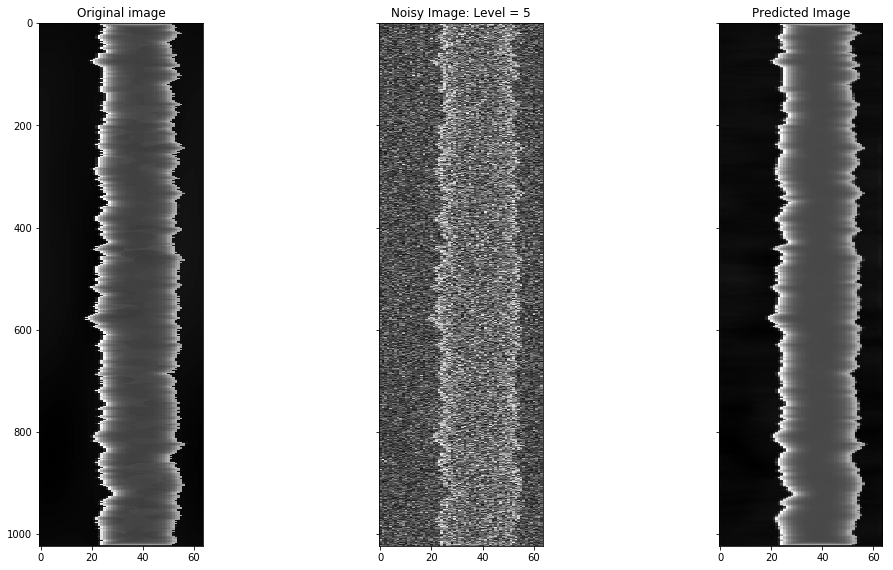

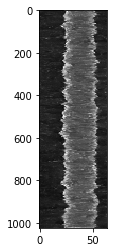

0.83984375 0.12109375
0.779106855392456 0.1212226152420044
1.2855244727941886 -0.3689278945938119


In [118]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})


ax[1].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[1].set_title('Noisy Image: Level = {}'.format(noise))

ax[2].imshow(impredict, cmap = 'gray', aspect= 0.2)
ax[2].set_title('Predicted Image')

ax[0].imshow(im,cmap = 'gray',aspect = 0.2)
#ax[2].set_title('Original image with sigma = {}nm, Xi = {}nm, alpha = {}, width = {} pixels'.format(sigma, Xi, alpha, width))
ax[0].set_title('Original image')

fig.tight_layout()
plt.savefig('noisy_lines.png')
plt.show()

import scipy.io as spio

#mat2 = spio.loadmat(path + 'Image2.mat', squeeze_me=True)
#DnCNN = np.array(mat2['image1'])
DnCNN_file = path + 'DnCNN_images2/DnCNN_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + \
                    "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + \
                    '_' + str(noise) + '.tiff'

DnCNN = np.array(Image.open(DnCNN_file))

DnCNN = DnCNN/256

plt.imshow(DnCNN,cmap = 'gray', aspect= 0.2)
plt.show()

#plt.imshow(np.abs(im - impredict), cmap = 'gray',aspect= 0.2)
#plt.show()


print(np.max(im), np.min(im))
print(np.max(impredict), np.min(impredict))
print(np.max(imnoisy), np.min(imnoisy))

24.464734278777943
PSNR noisy image = 12.38494864715875, PSNR predicted image = 28.73440501251645
MSE noisy image = 0.057743770054452206, MSE predicted image = 0.0013383185534827917


c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\skimage\restoration\_denoise.py:478: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return pywt.waverecn(denoised_coeffs, wavelet)[original_extent]


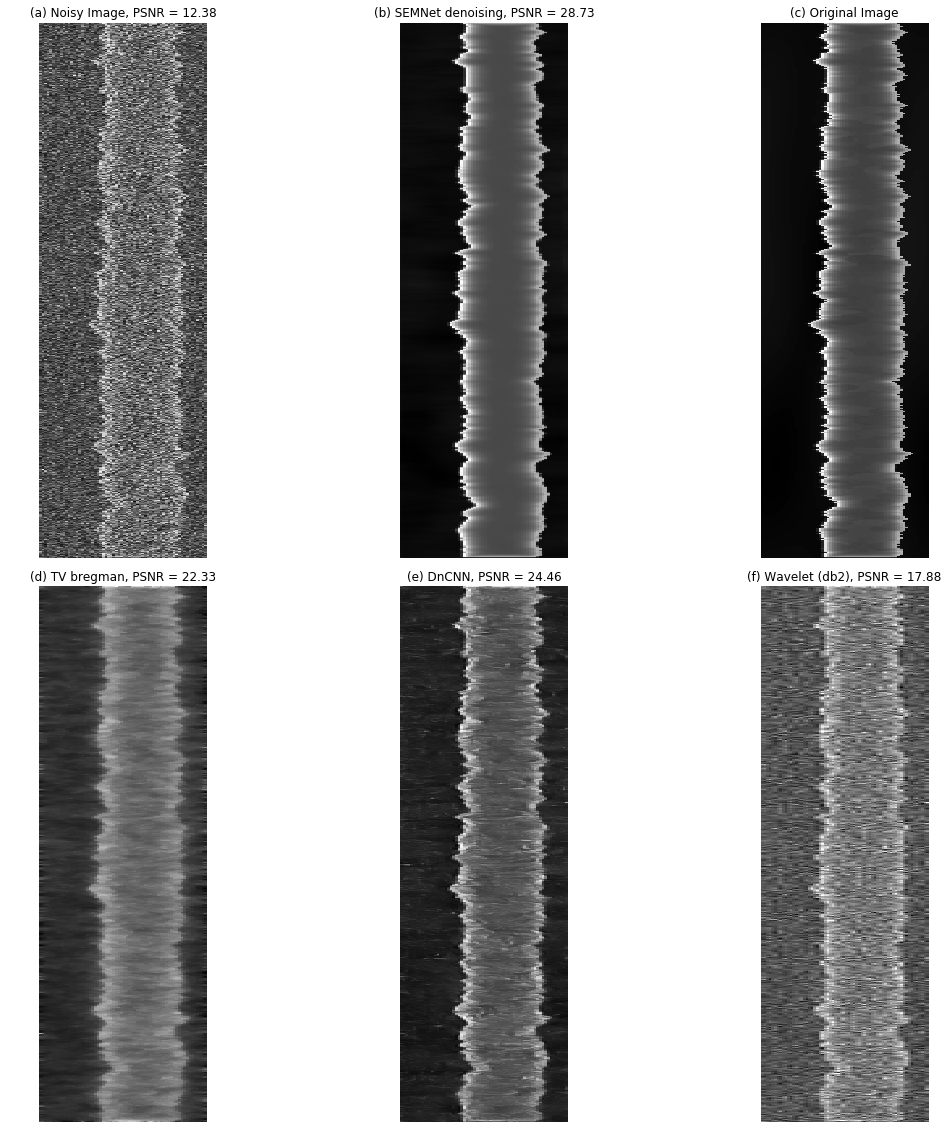

In [119]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, denoise_tv_bregman)
from skimage import measure
"""
impredict = (256*impredict).astype(int)
im = (256*im).astype(int)
imnoisy = (256*imnoisy).astype(int)

impredict = impredict.astype(float)
imnoisy = imnoisy.astype(float)
im = im.astype(float)

im = im/256
imnoisy = imnoisy/256
impredict = impredict/256
"""

psnr_DnCNN = measure.compare_psnr(im,DnCNN)
print(psnr_DnCNN)

psnr_noisy = measure.compare_psnr(im,imnoisy)
psnr_predict = measure.compare_psnr(im,impredict)
mse_noisy = measure.compare_mse(im, imnoisy)
mse_predict = measure.compare_mse(im, impredict)

print('PSNR noisy image = {}, PSNR predicted image = {}'.format(psnr_noisy,psnr_predict))
print('MSE noisy image = {}, MSE predicted image = {}'.format(mse_noisy,mse_predict))


# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma

im_denoise_tv_bregman = denoise_tv_bregman(imnoisy, weight = 1)
psnr_tv = measure.compare_psnr(im,im_denoise_tv_bregman)

#im_denoise_wavelet_sym9 = denoise_wavelet(imnoisy, wavelet='sym9', multichannel=False)
#psnr_wavelet_sym9 = measure.compare_psnr(im, im_denoise_wavelet_sym9)

im_denoise_wavelet_db2 = denoise_wavelet(imnoisy, wavelet='db2', multichannel=False)
psnr_wavelet_db2 = measure.compare_psnr(im, im_denoise_wavelet_db2)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 16), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

plt.gray()


ax[0, 0].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[0, 0].axis('off')
ax[0, 0].set_title('(a) Noisy Image, PSNR = {0:.4g}'.format(psnr_noisy))

ax[0, 1].imshow(impredict,cmap = 'gray',aspect= 0.2)
ax[0, 1].axis('off')
ax[0, 1].set_title('(b) SEMNet denoising, PSNR = {0:.4g}'.format(psnr_predict))

ax[0, 2].imshow(im,cmap = 'gray',aspect= 0.2)
ax[0, 2].axis('off')
ax[0, 2].set_title('(c) Original Image')

ax[1, 0].imshow(im_denoise_tv_bregman, cmap = 'gray',aspect= 0.2)
ax[1, 0].axis('off')
ax[1, 0].set_title('(d) TV bregman, PSNR = {0:.4g}'.format(psnr_tv))

ax[1, 1].imshow(DnCNN,cmap = 'gray',aspect= 0.2)
ax[1, 1].axis('off')
ax[1, 1].set_title('(e) DnCNN, PSNR = {0:.4g}'.format(psnr_DnCNN))

#ax[1, 1].imshow(im_denoise_wavelet_sym9,cmap = 'gray',aspect= 0.2)
#ax[1, 1].axis('off')
#ax[1, 1].set_title('(e) Wavelet denoising (sym9), PSNR = {0:.4g}'.format(psnr_wavelet_sym9))

ax[1, 2].imshow(im_denoise_wavelet_db2,cmap = 'gray',aspect= 0.2)
ax[1, 2].axis('off')
ax[1, 2].set_title('(f) Wavelet (db2), PSNR = {0:.4g}'.format(psnr_wavelet_db2))


fig.tight_layout()
#plt.savefig('denoisers.png')
plt.show()

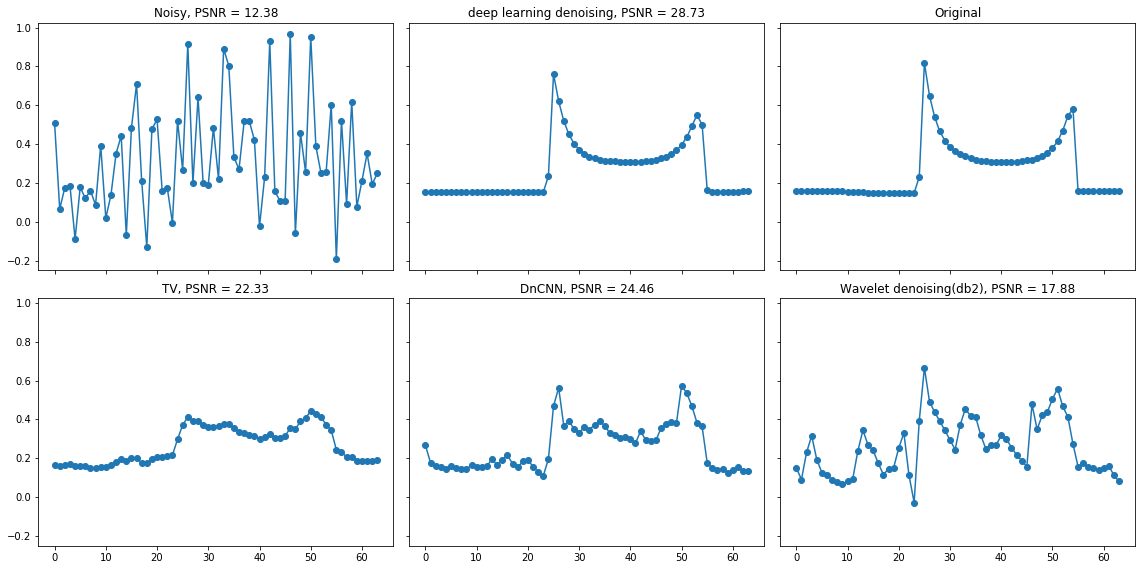

In [120]:
from scipy import ndimage as ndi
from skimage import feature


# display results
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].plot(imnoisy[100,:],'-o')
#ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy, PSNR = {0:.4g}'.format(psnr_noisy))

ax[0, 1].plot(impredict[100,:],'-o')
#ax[0, 1].axis('off')
ax[0, 1].set_title('deep learning denoising, PSNR = {0:.4g}'.format(psnr_predict))

ax[0, 2].plot(im[100,:],'-o')
#ax[0, 2].axis('off')
ax[0, 2].set_title('Original')

ax[1, 0].plot(im_denoise_tv_bregman[100,:], '-o')
#ax[1, 0].axis('off')
ax[1, 0].set_title('TV, PSNR = {0:.4g}'.format(psnr_tv))

ax[1, 1].plot(DnCNN[100,:],'-o')
#ax[1, 1].axis('off')
ax[1, 1].set_title('DnCNN, PSNR = {0:.4g}'.format(psnr_DnCNN))


ax[1, 2].plot(im_denoise_wavelet_db2[100,:],'-o')
#ax[1, 2].axis('off')
ax[1, 2].set_title('Wavelet denoising(db2), PSNR = {0:.4g}'.format(psnr_wavelet_db2))


fig.tight_layout()

plt.show()

Linescan Original SEMNet TV_bregman DnCNN wavelet (db2)
0.6750143450489645 0.6983890743309497 0.7399951880906871 2.039330966690285 1.6089090218842927 2.882283775336231
467.0


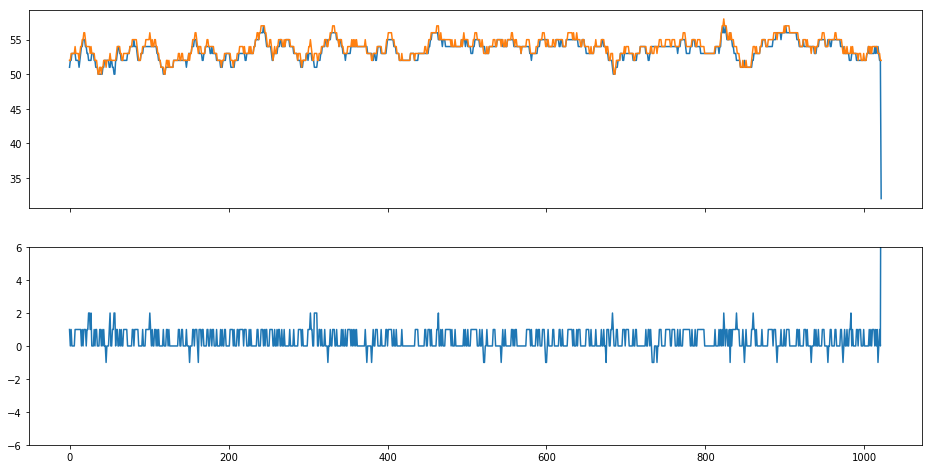

In [121]:
from skimage.filters import roberts, sobel, scharr
from scipy.signal import find_peaks    # To get maxima

#linescan_file = path + 'linescans\\linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'

linescan = []
with open(linescan_file,'r') as f:
    for line in f:
        a, b = line.split(',')
        linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift

ledge_im = np.zeros((1024))
redge_im = 63*np.ones((1024))

ledge_imnoisy = np.zeros((1024))
redge_imnoisy = 63*np.ones((1024))

ledge_impredict = np.zeros((1024))
redge_impredict = 63*np.ones((1024))

ledge_tv = np.zeros((1024))
redge_tv = 63*np.ones((1024))

ledge_DnCNN = np.zeros((1024))
redge_DnCNN = 63*np.ones((1024))

ledge_wavelet_db2 = np.zeros((1024))
redge_wavelet_db2 = 63*np.ones((1024))

dist = width//4
def left_right_peak(image, dist):
    peaks, h = find_peaks(image[i,:], height = 0.2, distance = dist)    # height 0.1 and distance 5
    h_index = np.flip(np.argsort(h['peak_heights']))[:2]
    left_peak = peaks[h_index].min()
    right_peak = peaks[h_index].max()
    
    return left_peak, (right_peak + 1)

for i in range(1024):
    ledge_im[i], redge_im[i] = left_right_peak(im, dist)
    ledge_imnoisy[i], redge_imnoisy[i] = left_right_peak(imnoisy, dist)
    ledge_impredict[i], redge_impredict[i] = left_right_peak(impredict, dist)
    ledge_tv[i], redge_tv[i] = left_right_peak(im_denoise_tv_bregman, dist)
    ledge_DnCNN[i], redge_DnCNN[i] = left_right_peak(DnCNN, dist)
    ledge_wavelet_db2[i], redge_wavelet_db2[i] = left_right_peak(im_denoise_wavelet_db2, dist)
    
    
    
"""
redge_im = np.argmax(np.fliplr(edges_im), axis = 1)                       #[13:1014]
redge_imnoisy = np.argmax(np.fliplr(edges_imnoisy), axis = 1)             #[13:1014]
redge_impredict = np.argmax(np.fliplr(edges_impredict), axis = 1)         #[13:1014]
redge_tv = np.argmax(np.fliplr(edges_im_tv), axis = 1)                    #[13:1014]
redge_DnCNN = np.argmax(np.fliplr(edges_im_DnCNN), axis = 1)              #[13:1014]
redge_wavelet_db2 = np.argmax(np.fliplr(edges_im_wavelet_db2), axis = 1)  #[13:1014]


redge_im = 63 - redge_im
redge_imnoisy = 63 - redge_imnoisy
redge_impredict = 63 - redge_impredict
redge_tv = 63 - redge_tv
redge_DnCNN = 63 - redge_DnCNN
redge_wavelet_db2 = 63 - redge_wavelet_db2

"""

print('Linescan', 'Original', 'SEMNet', 'TV_bregman', 'DnCNN', 'wavelet (db2)')
print(rightline.round().astype(int)[1:1023].std()/2, redge_im[1:1023].std()/2, \
      redge_impredict[1:1023].std()/2, redge_tv[1:1023].std()/2, redge_DnCNN[1:1023].std()/2, \
      redge_wavelet_db2[1:1023].std()/2)

rRMSE_im = np.sqrt(((rightline.round().astype(int) - redge_im)**2).mean())                      
rRMSE_imnoisy = np.sqrt(((rightline.round().astype(int) - redge_imnoisy)**2).mean())
rRMSE_impredict = np.sqrt(((rightline.round().astype(int) - redge_impredict)**2).mean())  
rRMSE_tv = np.sqrt(((rightline.round().astype(int) - redge_tv)**2).mean()) 
rRMSE_DnCNN = np.sqrt(((rightline.round().astype(int) - redge_DnCNN)**2).mean())  
rRMSE_wavelet_db2 = np.sqrt(((rightline.round().astype(int) - redge_wavelet_db2)**2).mean())

#print(rRMSE_im, rRMSE_impredict, rRMSE_tv, rRMSE_DnCNN, rRMSE_wavelet_db2)

print(np.abs((rightline.round().astype(int)[1:1023] - redge_impredict[1:1023])).sum())


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8),sharex=True, sharey=False)

ax[0].plot(redge_impredict[1:1023])
ax[0].plot(rightline.round().astype(int)[1:1023])


ax[1].plot(rightline.round().astype(int)[1:1023] - redge_impredict[1:1023])
ax[1].set_ylim(-6,6)
plt.show()

Linescan Original SEMNet TV_bregman DnCNN wavelet (db2)
0.7553898430951133 0.7726280438082676 0.7561260248543155 0.9646028841530622 0.9141122030622818 2.219035329608229
257.0


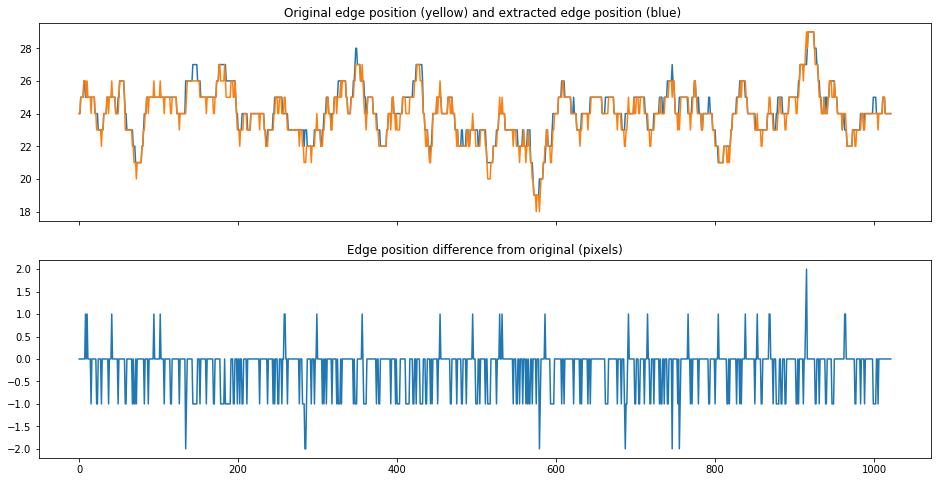

In [122]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8),sharex=True, sharey=False)
"""
ledge_im = np.argmax(edges_im, axis = 1)                            #[13:1014]
ledge_imnoisy = np.argmax(edges_imnoisy, axis = 1)                  #[13:1014]
ledge_impredict = np.argmax(edges_impredict, axis = 1)              #[13:1014]
ledge_tv = np.argmax(edges_im_tv, axis = 1)                         #[13:1014]
ledge_DnCNN = np.argmax(edges_im_DnCNN, axis = 1)                   #[13:1014]
ledge_wavelet_db2 = np.argmax(edges_im_wavelet_db2, axis = 1)       #[13:1014]

ledge_im = ledge_im + 1
ledge_imnoisy = ledge_imnoisy + 1
ledge_impredict = ledge_impredict + 1
ledge_tv = ledge_tv + 1
ledge_DnCNN = ledge_DnCNN + 1
ledge_wavelet_db2 = ledge_wavelet_db2 + 1
"""

print('Linescan', 'Original', 'SEMNet', 'TV_bregman', 'DnCNN', 'wavelet (db2)')
print(leftline.astype(int)[1:1023].std()/2, ledge_im[1:1023].std()/2, \
      ledge_impredict[1:1023].std()/2, ledge_tv[1:1023].std()/2, ledge_DnCNN[1:1023].std()/2, \
      ledge_wavelet_db2[1:1023].std()/2)

lRMSE_im = np.sqrt(((leftline.round().astype(int) - ledge_im)**2).mean())                      
lRMSE_imnoisy = np.sqrt(((leftline.round().astype(int) - ledge_imnoisy)**2).mean())
lRMSE_impredict = np.sqrt(((leftline.round().astype(int) - ledge_impredict)**2).mean())  
lRMSE_tv = np.sqrt(((leftline.round().astype(int) - ledge_tv)**2).mean()) 
lRMSE_DnCNN = np.sqrt(((leftline.round().astype(int) - ledge_DnCNN)**2).mean())  
lRMSE_wavelet_db2 = np.sqrt(((leftline.round().astype(int) - ledge_wavelet_db2)**2).mean())

#print(lRMSE_im, lRMSE_impredict, lRMSE_tv, lRMSE_DnCNN, lRMSE_wavelet_db2)

print(np.abs(leftline.round().astype(int)[1:1023] - ledge_impredict[1:1023]).sum())

ax[0].plot(ledge_impredict[1:1023])
ax[0].plot(leftline.round().astype(int)[1:1023])
ax[0].set_title('Original edge position (yellow) and extracted edge position (blue) ')
ax[1].plot(leftline.round().astype(int)[1:1023] - ledge_impredict[1:1023])
ax[1].set_title('Edge position difference from original (pixels)')
plt.show()